In [1]:
import shap
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2 
from sklearn.datasets import make_regression
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
import matplotlib.pylab as pl
import numpy as np
import pandas as pd
import xarray as xr
from scipy import signal
import copy
from netCDF4 import Dataset, num2date, date2num
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as patches
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cmaps
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib import cm
from scipy.optimize import curve_fit


from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.model_selection import train_test_split, cross_val_score
from scipy.stats import linregress
import ruptures as rpt
import statsmodels.api as sm
import matplotlib.patches as patches
from scipy.interpolate import RegularGridInterpolator

In [2]:
import scipy
import scipy.stats as ss
import scipy.signal
from scipy.interpolate import griddata
from scipy.signal import argrelmin
from scipy.ndimage import interpolation
from scipy.stats import genextreme as gev
import scipy.stats.mstats as mstats
import math
from math import log10, floor
import os
import dask.diagnostics as dd
import dask.array as da
from dask.diagnostics import ProgressBar
pbar = ProgressBar() 
import seaborn as sns
from sklearn import linear_model
import pickle

In [3]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Evaluate fits
def evaluate_fit(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return r2, mse, mae

def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x: k1*x + y0-k1*x0, lambda x: k2*x + y0-k2*x0])


In [4]:
def remove_seasonal(var,yearN,stepN):
    var_re = np.zeros_like(var)*0.0
    for i_box in range(stepN):
        temp1 = np.array([var[stepN*i_year+i_box] for i_year in range(yearN)])
        if (i_box>=2)&(i_box<=362):
            temp = []
            for i_year in range(0, yearN):
                temp.extend(var[stepN*i_year+i_box-2:stepN*i_year+i_box+3] )
            temp = np.array(temp)
        elif i_box<2:
            temp = []
            temp.extend(var[0:5])
            for i_year in range(1, yearN):
                temp.extend(var[stepN*i_year+i_box-2:stepN*i_year+i_box+3] )
            temp = np.array(temp)
        else:
            temp = []
            for i_year in range(0, yearN-1):
                temp.extend(var[stepN*i_year+i_box-2:stepN*i_year+i_box+3] )
            temp.extend(var[-5:])
            temp = np.array(temp)
            
        temp1 = temp1 - np.array(len(temp1)*[np.nanmean(temp,axis=0)])

        for i_year in range(yearN):
            var_re[stepN*i_year+i_box]  = temp1[i_year]
    return var_re

def detrend(var,yearN,stepN):
    var_detrend = np.zeros_like(var)*0.0
    for i_year in range(yearN):
        temp = np.array(var[stepN*i_year:stepN*i_year+stepN] )
        if i_year in range(2,yearN-2):
            temp1 = np.nanmean(np.array(var[stepN*(i_year-2):stepN*(i_year+3)] ),axis=0)
        elif i_year in range(2):
            temp1 = np.nanmean(np.array(var[:stepN*5] ),axis=0)
        else:
            temp1 = np.nanmean(np.array(var[-stepN*5:] ),axis=0)

        temp = temp - np.array(len(temp)*[temp1])
        
        var_detrend[stepN*i_year:stepN*i_year+stepN]  = temp
    return var_detrend


In [5]:
def standard(var,yearN,stepN):
    return (var-np.nanmean(var))/np.nanstd(var)
def standard_re(var,yearN,stepN):
    return (var-np.nanmean(var))/np.nanstd(var),np.nanmean(var),np.nanstd(var)

In [6]:
import numpy as np
from scipy.signal import find_peaks

def find_first_negative(array):
    # Loop through each element in the array
    for index, value in enumerate(array):
        # Check if the current element is negative (reaching -0.5)
        if value <-0.5:
            return index  # Return the index and the negative value
    return len(array)  # Return None if no negative value is found

# basic  

In [7]:

NCData = Dataset(r'C:/Users/yinglint/Desktop/code_test/Western_Europe/WEU_land_sea_mask_2023_01_01_1x1.nc')
land_mask = np.squeeze(NCData.variables['var172'][:])
lon_WEU1= NCData.variables['lon'][:]
lat_WEU1 = NCData.variables['lat'][:]
LON_WEU1, LAT_WEU1 = np.meshgrid(lon_WEU1, lat_WEU1)
NCData.close()

#### CEU boundary
bnd_l = 0
bnd_r = bnd_l+14
bnd_b = 44
bnd_u =bnd_b+10

In [8]:
startyear = 1950
endyear = 2023

# load CMIP6 data

In [ ]:
JJA_index_CMIP6 = []
year_era5_all_CMIP6 = []
for modelname in ['EC-Earth3','NorESM2-MM','NorESM2-LM',
                  'ACCESS-CM2','CanESM5','IPSL-CM6A-LR',
                  'MPI-ESM1-2-HR','MPI-ESM1-2-LR',
                  'INM-CM4-8','INM-CM5-0','UKESM1-0-LL','MIROC6']:
    NCData = Dataset(r'C:/Users/yinglint/Desktop/code_test/Western_Europe/WEU_t2mmax_1950_2023_del29_3dmean_'+modelname+'.nc')
    t2m_ml = np.squeeze(NCData.variables['tasmax'][:,::-1,:])
    lon_WEU_ml= NCData.variables['lon'][:]
    lat_WEU_ml = NCData.variables['lat'][:][::-1]
    LON_WEU_ml, LAT_WEU_ml = np.meshgrid(lon_WEU_ml, lat_WEU_ml)
    time = NCData.variables['time']
    dates = list(num2date(time[:], time.units, time.calendar))
    year_era5_all_ml = np.array([date.year for date in dates])
    mon_era5_all_ml = np.array([date.month for date in dates])
    day_era5_all_ml = np.array([date.day for date in dates])
    NCData.close()
    print(modelname+str(len(year_era5_all_ml )))
    print(lon_WEU_ml)
    print(lat_WEU_ml) 

######## basic info

    yearindex_ml = np.where((year_era5_all_ml>=startyear)&(year_era5_all_ml<=endyear))[0]
    year_era5_all_ml = year_era5_all_ml[yearindex_ml]
    mon_era5_all_ml = mon_era5_all_ml[yearindex_ml]
    day_era5_all_ml = day_era5_all_ml[yearindex_ml]

    yearN_ml = endyear-startyear+1
    stepN_ml = np.int(len(year_era5_all_ml)/yearN_ml)
    print(yearN_ml)
    print(stepN_ml)
    JJA_index_ml = np.where(np.in1d(mon_era5_all_ml,[6,7,8]))[0]
    JJA_index_CMIP6.append(JJA_index_ml)
    year_era5_all_CMIP6.append(year_era5_all_ml )

EC-Earth38954
[-9. -8. -7. -6. -5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.  6.  7.  8.
  9. 10. 11. 12. 13. 14.]
[55. 54. 53. 52. 51. 50. 49. 48. 47. 46. 45. 44. 43. 42. 41. 40. 39. 38.
 37.]
74
121
NorESM2-MM8954
[-9. -8. -7. -6. -5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.  6.  7.  8.
  9. 10. 11. 12. 13. 14.]
[55. 54. 53. 52. 51. 50. 49. 48. 47. 46. 45. 44. 43. 42. 41. 40. 39. 38.
 37.]
74
121
NorESM2-LM8954
[-9. -8. -7. -6. -5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.  6.  7.  8.
  9. 10. 11. 12. 13. 14.]
[55. 54. 53. 52. 51. 50. 49. 48. 47. 46. 45. 44. 43. 42. 41. 40. 39. 38.
 37.]
74
121
ACCESS-CM28954
[-9. -8. -7. -6. -5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.  6.  7.  8.
  9. 10. 11. 12. 13. 14.]
[55. 54. 53. 52. 51. 50. 49. 48. 47. 46. 45. 44. 43. 42. 41. 40. 39. 38.
 37.]
74
121
CanESM58954
[-9. -8. -7. -6. -5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.  6.  7.  8.
  9. 10. 11. 12. 13. 14.]
[55. 54. 53. 52. 51. 50. 49. 48. 47. 46. 45. 44. 43. 42. 41. 40. 39. 38.
 37.]
74
121
IPSL

In [10]:
len(year_era5_all_CMIP6[-3])

8831

In [ ]:


JJA_mean_CMIP6 = []
t2m_region_CMIP6 = []
t2m_region_re_de_CMIP6  = []
SM_region_CMIP6  = []
Z500_region_re_de_CMIP6 = []
b_temp0_CMIP6 = []
b_temp1_CMIP6 = []
b_temp2_CMIP6 = []
HW_flag_CMIP6 = []
R2_ML_CMIP6 = []
for modelname in ['EC-Earth3','NorESM2-MM','NorESM2-LM',
                  'ACCESS-CM2','CanESM5','IPSL-CM6A-LR',
                  'MPI-ESM1-2-HR','MPI-ESM1-2-LR',
                  'INM-CM4-8','INM-CM5-0','UKESM1-0-LL','MIROC6']:
    NCData = Dataset(r'C:/Users/yinglint/Desktop/code_test/Western_Europe/WEU_t2mmax_1950_2023_del29_3dmean_'+modelname+'.nc')
    t2m_ml = np.squeeze(NCData.variables['tasmax'][:,::-1,:])
    lon_WEU_ml= NCData.variables['lon'][:]
    lat_WEU_ml = NCData.variables['lat'][:][::-1]
    LON_WEU_ml, LAT_WEU_ml = np.meshgrid(lon_WEU_ml, lat_WEU_ml)
    time = NCData.variables['time']
    dates = list(num2date(time[:], time.units, time.calendar))
    year_era5_all_ml = np.array([date.year for date in dates])
    mon_era5_all_ml = np.array([date.month for date in dates])
    day_era5_all_ml = np.array([date.day for date in dates])
    NCData.close()
    print(modelname+str(len(year_era5_all_ml )))
    print(lon_WEU_ml)
    print(lat_WEU_ml) 

######## basic info

    yearindex_ml = np.where((year_era5_all_ml>=startyear)&(year_era5_all_ml<=endyear))[0]
    year_era5_all_ml = year_era5_all_ml[yearindex_ml]
    mon_era5_all_ml = mon_era5_all_ml[yearindex_ml]
    day_era5_all_ml = day_era5_all_ml[yearindex_ml]

    yearN_ml = endyear-startyear+1
    stepN_ml = np.int(len(year_era5_all_ml)/yearN_ml)
    print(yearN_ml)
    print(stepN_ml)
    JJA_index_ml = np.where(np.in1d(mon_era5_all_ml,[6,7,8]))[0]
    after_1979_ml = np.where(year_era5_all_ml[JJA_index_ml]>=1979)[0]

######## t2m
    t2m_region_ml = np.array([np.nanmean(i[(land_mask>0.3)&(LON_WEU_ml>=bnd_l)&(LON_WEU_ml<=bnd_r)&(LAT_WEU_ml>=bnd_b)&(LAT_WEU_ml<=bnd_u)]) for i in t2m_ml])[yearindex_ml]
    t2m_region_ml = np.array([np.nanmean(i[(land_mask>0.3)&(LON_WEU_ml>=bnd_l)&(LON_WEU_ml<=bnd_r)&(LAT_WEU_ml>=bnd_b)&(LAT_WEU_ml<=bnd_u)]) for i in t2m_ml])[yearindex_ml]
    t2m_region_re_ml = copy.deepcopy(remove_seasonal(t2m_region_ml,yearN_ml,stepN_ml))
    t2m_region_re_std_ml = copy.deepcopy(standard(t2m_region_re_ml,yearN_ml,stepN_ml))
    t2m_region_re_de_ml = copy.deepcopy(detrend(t2m_region_re_ml,yearN_ml,stepN_ml))
    t2m_region_re_de_std_ml = copy.deepcopy(standard(t2m_region_re_de_ml,yearN_ml,stepN_ml))
    t2m_ave1_ml = copy.deepcopy(standard_re(t2m_region_re_de_ml,yearN_ml,stepN_ml))[1]
    t2m_std1_ml = copy.deepcopy(standard_re(t2m_region_re_de_ml,yearN_ml,stepN_ml))[2]

    basevalue1_ml = np.nanmean(t2m_region_ml[JJA_index_ml])
    basevalue1_0_ml = np.nanmean(t2m_region_ml[JJA_index_ml][(year_era5_all_ml[JJA_index_ml]<=2023)&(year_era5_all_ml[JJA_index_ml]>=1979)])
    basevalue1_1_ml = np.nanmean(t2m_region_ml[JJA_index_ml][(year_era5_all_ml[JJA_index_ml]<=1999)&(year_era5_all_ml[JJA_index_ml]>=1979)])
    basevalue1_2_ml = np.nanmean(t2m_region_ml[JJA_index_ml][(year_era5_all_ml[JJA_index_ml]<=2023)&(year_era5_all_ml[JJA_index_ml]>=2003)])

    print(basevalue1_0_ml)


###############sm and z500
    NCData = Dataset(r'C:/Users/yinglint/Desktop/code_test/Western_Europe/WEU_zg500_1950_2023_del29_3dmean_'+modelname+'.nc')
    Z500_ml = np.squeeze(NCData.variables['zg500'][:,::-1,:])
    NCData.close()


    NCData = Dataset(r'C:/Users/yinglint/Desktop/code_test/Western_Europe/WEU_mrsos_1950_2023_del29_3dmean_'+modelname+'.nc')
    SM_ml = np.squeeze(NCData.variables['mrsos'][:,::-1,:])/100
    NCData.close()


    Z500_region_ml = np.array([np.nanmean(i[(land_mask>0.3)&(LON_WEU_ml>=bnd_l)&(LON_WEU_ml<=bnd_r)&(LAT_WEU_ml>=bnd_b)&(LAT_WEU_ml<=bnd_u)]) for i in Z500_ml])[yearindex_ml]
    Z500_region_re_ml = copy.deepcopy(remove_seasonal(Z500_region_ml,yearN_ml,stepN_ml))
    Z500_region_re_std_ml = copy.deepcopy(standard(Z500_region_re_ml,yearN_ml,stepN_ml))
    Z500_region_re_de_ml = copy.deepcopy(detrend(Z500_region_re_ml,yearN_ml,stepN_ml))
    Z500_region_re_de_std_ml = copy.deepcopy(standard(Z500_region_re_de_ml,yearN_ml,stepN_ml))
    Z500_ave1_ml = copy.deepcopy(standard_re(Z500_region_re_de_ml,yearN_ml,stepN_ml))[1]
    Z500_std1_ml = copy.deepcopy(standard_re(Z500_region_re_de_ml,yearN_ml,stepN_ml))[2]

    SM_region_ml = np.array([np.nanmean(i[(land_mask>0.3)&(LON_WEU_ml>=bnd_l)&(LON_WEU_ml<=bnd_r)&(LAT_WEU_ml>=bnd_b)&(LAT_WEU_ml<=bnd_u)]) for i in SM_ml])[yearindex_ml]
    SM_region_re_ml = copy.deepcopy(remove_seasonal(SM_region_ml,yearN_ml,stepN_ml))
    SM_region_re_std_ml = copy.deepcopy(standard(SM_region_re_ml,yearN_ml,stepN_ml))
    SM_region_re_de_ml = copy.deepcopy(detrend(SM_region_re_ml,yearN_ml,stepN_ml))
    SM_region_re_de_std_ml = copy.deepcopy(standard(SM_region_re_de_ml,yearN_ml,stepN_ml))
    SM_ave1_ml = copy.deepcopy(standard_re(SM_region_re_de_ml,yearN_ml,stepN_ml))[1]
    SM_std1_ml = copy.deepcopy(standard_re(SM_region_re_de_ml,yearN_ml,stepN_ml))[2]

################shap

    shap_interaction_values_ml = np.load('C:/Users/yinglint/Desktop/code_test/Western_Europe/Tmax_ver1.0/Simply_GradientBoosting_shap_interaction_values_run_mean_'+str(startyear)+'_'+modelname+'.npy',allow_pickle='True')

    ## the sum of the three parts would be the standardized Tx anomaly

    b_temp1_ml = copy.deepcopy(shap_interaction_values_ml[:,0,0])
    b_temp2_ml = copy.deepcopy(shap_interaction_values_ml[:,1,1])
    b_temp0_ml = copy.deepcopy(2*shap_interaction_values_ml[:,0,1])

    b_temp3_ml = b_temp0_ml +b_temp1_ml+b_temp2_ml
    b_temp4_ml = b_temp3_ml*t2m_std1_ml+t2m_ave1_ml

    bb_temp1_ml = b_temp1_ml/b_temp3_ml*b_temp4_ml
    bb_temp2_ml = b_temp2_ml/b_temp3_ml*b_temp4_ml
    bb_temp0_ml = b_temp0_ml/b_temp3_ml*b_temp4_ml
    ## the sum of the three parts would be the standardized Tx anomaly
    y_pred_ml = np.load('C:/Users/yinglint/Desktop/code_test/Western_Europe/Tmax_ver1.0/Simply_GradientBoosting_y_all_predict_run_mean_'+str(startyear)+'_'+modelname+'.npy',allow_pickle='True')
    y_test_ml = np.array(t2m_region_re_de_std_ml[JJA_index_ml])

    ## get back to unstandardized Tx anomaly
    y_pred_ml = y_pred_ml*t2m_std1_ml+t2m_ave1_ml
    y_test_ml = y_test_ml*t2m_std1_ml+t2m_ave1_ml
    R2_ML = round(r2_score(y_test_ml[after_1979_ml ], y_pred_ml[after_1979_ml ]),2)
    ################################### HW_days


    data =  t2m_region_re_de_ml[JJA_index_ml ]
    y_data = year_era5_all_ml[JJA_index_ml]
    mon_data = mon_era5_all_ml[JJA_index_ml]
    day_data = day_era5_all_ml[JJA_index_ml]
    data1 = data[data>np.percentile(data[(y_data>=1979)&(y_data<=2023)],90)]

    ## HW events
    loc1 = np.where(data>np.percentile(data[y_data>=1979],90))[0]

    ## HW peaks
    peaks, _ = find_peaks(data, height=0)
    loc2 = peaks[np.isin(peaks, loc1)]
    ## HW periods
    HW_flag_ml = []

    for i in loc2:
        ## find out initialization date i_i
        if (mon_data[i]==6)&(day_data[i]<=3):
            HW_flag_ml.extend([i])
            continue
        elif (mon_data[i]==6)&(day_data[i]>3)&(day_data[i]<=6):
            jj=2
        elif (mon_data[i]==6)&(day_data[i]>6)&(day_data[i]<=9):
            jj=3
        elif (mon_data[i]==6)&(day_data[i]>9)&(day_data[i]<=12):
            jj=4
        else:
            jj=5
        array = data[i-jj:i+1]
        index = find_first_negative(array[::-1])
        # print(index)
        if index<=jj:
            i_i = index
        else:
            i_i = jj


        ## find out terminazition date i_e
        if (mon_data[i]==8)&(day_data[i]>=27):
            kk=1
        elif (mon_data[i]==8)&(day_data[i]>24)&(day_data[i]<=27):
            kk=2
        elif (mon_data[i]==8)&(day_data[i]>21)&(day_data[i]<=24):
            kk=3
        elif (mon_data[i]==8)&(day_data[i]>18)&(day_data[i]<=21):
            kk=4
        else:
            kk=5
        array = data[i:i+kk]
        index = find_first_negative(array)

        if index<=kk:
            i_e = index
        else:
            i_e = kk
        if i_e+i_i-1<2:
            continue

        ## HW_period = i_i - i_e   
        HW_flag_ml.extend(np.arange(i-i_i+1,i+i_e))


    HW_flag_new_ml = []

    for i in HW_flag_ml:
        if i in HW_flag_new_ml:
            continue
        else:
            HW_flag_new_ml.append(i)

    HW_flag_ml =np.array(HW_flag_new_ml)
 


    JJA_mean_CMIP6.append(basevalue1_0_ml)
    t2m_region_CMIP6.append(t2m_region_ml)
    t2m_region_re_de_CMIP6.append(t2m_region_re_de_ml)
    SM_region_CMIP6.append(SM_region_ml)
    Z500_region_re_de_CMIP6.append(Z500_region_re_de_ml)
    b_temp0_CMIP6.append(bb_temp0_ml)
    b_temp1_CMIP6.append(bb_temp1_ml)
    b_temp2_CMIP6.append(bb_temp2_ml)
    HW_flag_CMIP6.append(HW_flag_ml)
    R2_ML_CMIP6.append(R2_ML) 

EC-Earth38954
[-9. -8. -7. -6. -5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.  6.  7.  8.
  9. 10. 11. 12. 13. 14.]
[55. 54. 53. 52. 51. 50. 49. 48. 47. 46. 45. 44. 43. 42. 41. 40. 39. 38.
 37.]
74
121
294.43887
NorESM2-MM8954
[-9. -8. -7. -6. -5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.  6.  7.  8.
  9. 10. 11. 12. 13. 14.]
[55. 54. 53. 52. 51. 50. 49. 48. 47. 46. 45. 44. 43. 42. 41. 40. 39. 38.
 37.]
74
121
295.58847
NorESM2-LM8954
[-9. -8. -7. -6. -5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.  6.  7.  8.
  9. 10. 11. 12. 13. 14.]
[55. 54. 53. 52. 51. 50. 49. 48. 47. 46. 45. 44. 43. 42. 41. 40. 39. 38.
 37.]
74
121
295.66
ACCESS-CM28954
[-9. -8. -7. -6. -5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.  6.  7.  8.
  9. 10. 11. 12. 13. 14.]
[55. 54. 53. 52. 51. 50. 49. 48. 47. 46. 45. 44. 43. 42. 41. 40. 39. 38.
 37.]
74
121
294.24097
CanESM58954
[-9. -8. -7. -6. -5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.  6.  7.  8.
  9. 10. 11. 12. 13. 14.]
[55. 54. 53. 52. 51. 50. 49. 48. 47. 46. 45. 44. 43. 

# load smile data

In [ ]:
JJA_mean_LE = []
t2m_region_LE = []
t2m_region_re_de_LE  = []
SM_region_LE  = []
Z500_region_re_de_LE = []
b_temp0_LE = []
b_temp1_LE = []
b_temp2_LE = []
HW_flag_LE = []
for modelname in ['1231.001', '1231.002' ,'1231.003', '1231.004', '1231.005', '1231.006', '1231.007', '1231.008', '1231.009' ,'1231.010',
                   '1251.001' ,'1251.002', '1251.003', '1251.004', '1251.005' ,'1251.006' ,'1251.007', '1251.008' ,'1251.009', '1251.010' ,
                   '1281.001' ,'1281.002' ,'1281.003' ,'1281.004', '1281.005', '1281.006' ,'1281.007', '1281.008' ,'1281.009' ,'1281.010' ,
                   '1301.001', '1301.002' ,'1301.003', '1301.004' ,'1301.005' ,'1301.006' ,'1301.007', '1301.008' ,'1301.009' ,'1301.010']:
    NCData = Dataset(r'C:/Users/yinglint/Desktop/code_test/Western_Europe_CESM2_LE2/WEU_TSMX_CESM2_LE2_'+modelname+'_historical_ssp370_19500101_21001231_3dmean_1x1.nc')
    t2m = np.squeeze(NCData.variables['TSMX'][:,::-1,:])
    lon_WEU= NCData.variables['lon'][:]
    lat_WEU = NCData.variables['lat'][:][::-1]
    LON_WEU, LAT_WEU = np.meshgrid(lon_WEU, lat_WEU)
    time = NCData.variables['time']
    dates = list(num2date(time[:], time.units, time.calendar))
    year_era5_all = np.array([date.year for date in dates])
    mon_era5_all = np.array([date.month for date in dates])
    day_era5_all = np.array([date.day for date in dates])
    NCData.close()
    print(modelname+str(len(year_era5_all )))
    print(lon_WEU)
    print(lat_WEU) 

######## basic info
    startyear = 1950
    endyear = 2023
    yearindex = np.where((year_era5_all>=startyear)&(year_era5_all<=endyear))[0]
    year_era5_all = year_era5_all[yearindex]
    mon_era5_all = mon_era5_all[yearindex]
    day_era5_all = day_era5_all[yearindex]

    yearN = endyear-startyear+1
    stepN = np.int(len(year_era5_all)/yearN)
    print(yearN)
    print(stepN)
    JJA_index = np.where(np.in1d(mon_era5_all,[6,7,8]))[0]
    after_1979 = np.where(year_era5_all[JJA_index]>=1979)[0]

######## t2m
    t2m_region = np.array([np.nanmean(i[(land_mask>0.3)&(LON_WEU>=bnd_l)&(LON_WEU<=bnd_r)&(LAT_WEU>=bnd_b)&(LAT_WEU<=bnd_u)]) for i in t2m])[yearindex]
    t2m_region = np.array([np.nanmean(i[(land_mask>0.3)&(LON_WEU>=bnd_l)&(LON_WEU<=bnd_r)&(LAT_WEU>=bnd_b)&(LAT_WEU<=bnd_u)]) for i in t2m])[yearindex]
    t2m_region_re = copy.deepcopy(remove_seasonal(t2m_region,yearN,stepN))
    t2m_region_re_std = copy.deepcopy(standard(t2m_region_re,yearN,stepN))
    t2m_region_re_de = copy.deepcopy(detrend(t2m_region_re,yearN,stepN))
    t2m_region_re_de_std = copy.deepcopy(standard(t2m_region_re_de,yearN,stepN))
    t2m_ave1 = copy.deepcopy(standard_re(t2m_region_re_de,yearN,stepN))[1]
    t2m_std1 = copy.deepcopy(standard_re(t2m_region_re_de,yearN,stepN))[2]

    basevalue1 = np.nanmean(t2m_region[JJA_index])
    basevalue1_0 = np.nanmean(t2m_region[JJA_index][(year_era5_all[JJA_index]<=2023)&(year_era5_all[JJA_index]>=1979)])
    basevalue1_1 = np.nanmean(t2m_region[JJA_index][(year_era5_all[JJA_index]<=1999)&(year_era5_all[JJA_index]>=1979)])
    basevalue1_2 = np.nanmean(t2m_region[JJA_index][(year_era5_all[JJA_index]<=2023)&(year_era5_all[JJA_index]>=2003)])

    print(basevalue1_0)


###############sm and z500
    NCData = Dataset(r'C:/Users/yinglint/Desktop/code_test/Western_Europe_CESM2_LE2/WEU_Z500_CESM2_LE2_'+modelname+'_historical_ssp370_19500101_21001231_3dmean_1x1.nc')
    Z500 = np.squeeze(NCData.variables['Z500'][:,::-1,:])
    time = NCData.variables['time']
    dates = list(num2date(time[:], time.units, time.calendar))
    year_era5_all = np.array([date.year for date in dates])
    mon_era5_all = np.array([date.month for date in dates])
    day_era5_all = np.array([date.day for date in dates])
    NCData.close()


    NCData = Dataset(r'C:/Users/yinglint/Desktop/code_test/Western_Europe_CESM2_LE2/WEU_SOILWATER_10CM_CESM2_LE2_'+modelname+'_historical_ssp370_19500101_21001231_3dmean_1x1.nc')
    SM = np.squeeze(NCData.variables['SOILWATER_10CM'][:,::-1,:])/100
    time = NCData.variables['time']
    dates = list(num2date(time[:], time.units, time.calendar))
    year_era5_all = np.array([date.year for date in dates])
    mon_era5_all = np.array([date.month for date in dates])
    day_era5_all = np.array([date.day for date in dates])
    NCData.close()
    print(modelname+str(len(year_era5_all )))

    Z500_region = np.array([np.nanmean(i[(land_mask>0.3)&(LON_WEU>=bnd_l)&(LON_WEU<=bnd_r)&(LAT_WEU>=bnd_b)&(LAT_WEU<=bnd_u)]) for i in Z500])[yearindex]
    Z500_region_re = copy.deepcopy(remove_seasonal(Z500_region,yearN,stepN))
    Z500_region_re_std = copy.deepcopy(standard(Z500_region_re,yearN,stepN))
    Z500_region_re_de = copy.deepcopy(detrend(Z500_region_re,yearN,stepN))
    Z500_region_re_de_std = copy.deepcopy(standard(Z500_region_re_de,yearN,stepN))
    Z500_ave1 = copy.deepcopy(standard_re(Z500_region_re_de,yearN,stepN))[1]
    Z500_std1 = copy.deepcopy(standard_re(Z500_region_re_de,yearN,stepN))[2]

    SM_region = np.array([np.nanmean(i[(land_mask>0.3)&(LON_WEU>=bnd_l)&(LON_WEU<=bnd_r)&(LAT_WEU>=bnd_b)&(LAT_WEU<=bnd_u)]) for i in SM])[yearindex]
    SM_region_re = copy.deepcopy(remove_seasonal(SM_region,yearN,stepN))
    SM_region_re_std = copy.deepcopy(standard(SM_region_re,yearN,stepN))
    SM_region_re_de = copy.deepcopy(detrend(SM_region_re,yearN,stepN))
    SM_region_re_de_std = copy.deepcopy(standard(SM_region_re_de,yearN,stepN))
    SM_ave1 = copy.deepcopy(standard_re(SM_region_re_de,yearN,stepN))[1]
    SM_std1 = copy.deepcopy(standard_re(SM_region_re_de,yearN,stepN))[2]

################shap

    shap_interaction_values = np.load('C:/Users/yinglint/Desktop/code_test/Western_Europe_CESM2_LE2/'+str(startyear)+'_'+str(endyear)+'/Simply_GradientBoosting_shap_interaction_values_run_mean_'+str(startyear)+'_'+str(endyear)+'_'+modelname+'.npy',allow_pickle='True')
    b_temp1 = copy.deepcopy(shap_interaction_values[:,0,0])
    b_temp2 = copy.deepcopy(shap_interaction_values[:,1,1])
    b_temp0 = copy.deepcopy(2*shap_interaction_values[:,0,1])

    b_temp3 = b_temp0 +b_temp1+b_temp2
    b_temp4 = b_temp3*t2m_std1+t2m_ave1

    bb_temp1 = b_temp1/b_temp3*b_temp4
    bb_temp2 = b_temp2/b_temp3*b_temp4
    bb_temp0 = b_temp0/b_temp3*b_temp4
    ## the sum of the three parts would be the standardized Tx anomaly
    y_pred = np.load('C:/Users/yinglint/Desktop/code_test/Western_Europe_CESM2_LE2/'+str(startyear)+'_'+str(endyear)+'/Simply_GradientBoosting_y_all_predict_run_mean_'+str(startyear)+'_'+str(endyear)+'_'+modelname+'.npy',allow_pickle='True')
    y_test = np.array(t2m_region_re_de_std[JJA_index])

    ## get back to unstandardized Tx anomaly
    y_pred = y_pred*t2m_std1+t2m_ave1
    y_test = y_test*t2m_std1+t2m_ave1

    ################################### HW_days


    data =  t2m_region_re_de[JJA_index ]
    y_data = year_era5_all[JJA_index]
    mon_data = mon_era5_all[JJA_index]
    day_data = day_era5_all[JJA_index]
    data1 = data[data>np.percentile(data[y_data>=1979],90)]


    ## HW events
    loc1 = np.where(data>np.percentile(data[y_data>=1979],90))[0]

    ## HW peaks
    peaks, _ = find_peaks(data, height=0)
    loc2 = peaks[np.isin(peaks, loc1)]

    ## HW periods
    HW_flag = []
    HW_flag_loc = []
    for i in loc2:
        ## find out initialization date i_i
        if (mon_data[i]==6)&(day_data[i]<=3):
            HW_flag.extend([i])
            HW_flag_loc.extend([0])
            continue
        elif (mon_data[i]==6)&(day_data[i]>3)&(day_data[i]<=6):
            jj=2
        elif (mon_data[i]==6)&(day_data[i]>6)&(day_data[i]<=9):
            jj=3
        elif (mon_data[i]==6)&(day_data[i]>9)&(day_data[i]<=12):
            jj=4
        else:
            jj=5
        array = data[i-jj:i+1]
        index = find_first_negative(array[::-1])
        # print(index)
        if index<=jj:
            i_i = index
        else:
            i_i = jj


        ## find out terminazition date i_e
        if (mon_data[i]==8)&(day_data[i]>=27):
            kk=1
        elif (mon_data[i]==8)&(day_data[i]>24)&(day_data[i]<=27):
            kk=2
        elif (mon_data[i]==8)&(day_data[i]>21)&(day_data[i]<=24):
            kk=3
        elif (mon_data[i]==8)&(day_data[i]>18)&(day_data[i]<=21):
            kk=4
        else:
            kk=5
        array = data[i:i+kk]
        index = find_first_negative(array)

        if index<=kk:
            i_e = index
        else:
            i_e = kk
        if i_e+i_i-1<2:
            continue

        ## HW_period = i_i - i_e   
        HW_flag.extend(np.arange(i-i_i+1,i+i_e))
        HW_flag_loc.extend(np.arange(-i_i+1,i_e))


    HW_flag_new = []
    HW_flag_loc_new = []
    for i,j in zip(HW_flag,HW_flag_loc):
        if i in HW_flag_new:
            continue
        else:
            HW_flag_new.append(i)
            HW_flag_loc_new.append(j)
    HW_flag =np.array(HW_flag_new)
    HW_flag_loc =np.array(HW_flag_loc_new)


    JJA_mean_LE.append(basevalue1_0)
    t2m_region_LE.append(t2m_region)
    t2m_region_re_de_LE.append(t2m_region_re_de)
    SM_region_LE.append(SM_region)
    Z500_region_re_de_LE.append(Z500_region_re_de)
    b_temp0_LE.append(bb_temp0)
    b_temp1_LE.append(bb_temp1)
    b_temp2_LE.append(bb_temp2)
    HW_flag_LE.append(HW_flag)


1231.00118271
[-9. -8. -7. -6. -5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.  6.  7.  8.
  9. 10. 11. 12. 13. 14.]
[55. 54. 53. 52. 51. 50. 49. 48. 47. 46. 45. 44. 43. 42. 41. 40. 39. 38.
 37.]
74
121
300.7874
1231.00118271
1231.00218271
[-9. -8. -7. -6. -5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.  6.  7.  8.
  9. 10. 11. 12. 13. 14.]
[55. 54. 53. 52. 51. 50. 49. 48. 47. 46. 45. 44. 43. 42. 41. 40. 39. 38.
 37.]
74
121
300.61514
1231.00218271
1231.00318271
[-9. -8. -7. -6. -5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.  6.  7.  8.
  9. 10. 11. 12. 13. 14.]
[55. 54. 53. 52. 51. 50. 49. 48. 47. 46. 45. 44. 43. 42. 41. 40. 39. 38.
 37.]
74
121
300.24423
1231.00318271
1231.00418271
[-9. -8. -7. -6. -5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.  6.  7.  8.
  9. 10. 11. 12. 13. 14.]
[55. 54. 53. 52. 51. 50. 49. 48. 47. 46. 45. 44. 43. 42. 41. 40. 39. 38.
 37.]
74
121
300.26132
1231.00418271
1231.00518271
[-9. -8. -7. -6. -5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.  6.  7.  8.
  9. 10. 11. 12. 13. 1

# load era5 data

In [13]:
NCData = Dataset(r'C:/Users/yinglint/Desktop/code_test/Western_Europe/WEU_T2mmax_1950_2023_del29_3dmean_ERAland.nc')
t2m = np.squeeze(NCData.variables['var167'][:])
lon_WEU= NCData.variables['lon'][:]
lat_WEU = NCData.variables['lat'][:]
LON_WEU, LAT_WEU = np.meshgrid(lon_WEU, lat_WEU)
time = NCData.variables['time']
dates = list(num2date(time[:], time.units, time.calendar))
year_era5 = np.array([date.year for date in dates])
mon_era5 = np.array([date.month for date in dates])
day_era5 = np.array([date.day for date in dates])
NCData.close()


NCData = Dataset(r'C:/Users/yinglint/Desktop/code_test/Western_Europe/WEU_Z500_1950_2023_del29_3dmean.nc')
Z200 = np.squeeze(NCData.variables['var129'][:])/9.81
time = NCData.variables['time']
dates = list(num2date(time[:], time.units, time.calendar))
year_era5 = np.array([date.year for date in dates])
mon_era5 = np.array([date.month for date in dates])
day_era5 = np.array([date.day for date in dates])
NCData.close()


NCData = Dataset(r'C:/Users/yinglint/Desktop/code_test/Western_Europe/WEU_swvl1_1950_2023_del29_3dmean_ERAland.nc')
SM = np.squeeze(NCData.variables['var39'][:])
time = NCData.variables['time']
dates = list(num2date(time[:], time.units, time.calendar))
year_era5 = np.array([date.year for date in dates])
mon_era5 = np.array([date.month for date in dates])
day_era5 = np.array([date.day for date in dates])
NCData.close()


In [14]:
JJA_index = np.where(np.in1d(mon_era5,[6,7,8]))[0]
DJF_index = np.where(np.in1d(mon_era5,[12,1,2]))[0]
after_1979 = np.where(year_era5[JJA_index]>=1979)[0]

startyear = 1950
yearindex = np.where(year_era5>=startyear)[0]
year_era5 = year_era5[yearindex]
mon_era5 = mon_era5[yearindex]
day_era5 = day_era5[yearindex]

yearN = 2023-startyear+1
stepN = np.int(len(year_era5)/yearN)

In [15]:
Z200_region = np.array([np.nanmean(i[(land_mask>0.3)&(LON_WEU>=bnd_l)&(LON_WEU<=bnd_r)&(LAT_WEU>=bnd_b)&(LAT_WEU<=bnd_u)]) for i in Z200])[yearindex]
Z200_region_re = copy.deepcopy(remove_seasonal(Z200_region,yearN,stepN))
Z200_region_re_std = copy.deepcopy(standard(Z200_region_re,yearN,stepN))
Z200_region_re_de = copy.deepcopy(detrend(Z200_region_re,yearN,stepN))
Z200_region_re_de_std = copy.deepcopy(standard(Z200_region_re_de,yearN,stepN))
Z200_ave1 = copy.deepcopy(standard_re(Z200_region_re_de,yearN,stepN))[1]
Z200_std1 = copy.deepcopy(standard_re(Z200_region_re_de,yearN,stepN))[2]

SM_region = np.array([np.nanmean(i[(land_mask>0.3)&(LON_WEU>=bnd_l)&(LON_WEU<=bnd_r)&(LAT_WEU>=bnd_b)&(LAT_WEU<=bnd_u)]) for i in SM])[yearindex]
SM_region_re = copy.deepcopy(remove_seasonal(SM_region,yearN,stepN))
SM_region_re_std = copy.deepcopy(standard(SM_region_re,yearN,stepN))
SM_region_re_de = copy.deepcopy(detrend(SM_region_re,yearN,stepN))
SM_region_re_de_std = copy.deepcopy(standard(SM_region_re_de,yearN,stepN))
SM_ave1 = copy.deepcopy(standard_re(SM_region_re_de,yearN,stepN))[1]
SM_std1 = copy.deepcopy(standard_re(SM_region_re_de,yearN,stepN))[2]

t2m_region = np.array([np.nanmean(i[(land_mask>0.3)&(LON_WEU>=bnd_l)&(LON_WEU<=bnd_r)&(LAT_WEU>=bnd_b)&(LAT_WEU<=bnd_u)]) for i in t2m])[yearindex]
t2m_region_re = copy.deepcopy(remove_seasonal(t2m_region,yearN,stepN))
t2m_region_re_std = copy.deepcopy(standard(t2m_region_re,yearN,stepN))
t2m_region_re_de = copy.deepcopy(detrend(t2m_region_re,yearN,stepN))
t2m_region_re_de_std = copy.deepcopy(standard(t2m_region_re_de,yearN,stepN))
t2m_ave1 = copy.deepcopy(standard_re(t2m_region_re_de,yearN,stepN))[1]
t2m_std1 = copy.deepcopy(standard_re(t2m_region_re_de,yearN,stepN))[2]

In [16]:
shap_interaction_values = np.load('C:/Users/yinglint/Desktop/code_test/Western_Europe/Tmax_ver1.0/Simply_GradientBoosting_shap_interaction_values_run_mean_'+str(startyear)+'.npy',allow_pickle='True')

## the sum of the three parts would be the standardized Tx anomaly
y_pred = np.load('C:/Users/yinglint/Desktop/code_test/Western_Europe/Tmax_ver1.0/Simply_GradientBoosting_y_all_predict_run_mean_'+str(startyear)+'.npy',allow_pickle='True')
y_test = np.array(t2m_region_re_de_std[JJA_index])

## get back to unstandardized Tx anomaly
y_pred = y_pred*t2m_std1+t2m_ave1
y_test = y_test*t2m_std1+t2m_ave1

In [17]:
after_1979 = np.where(year_era5[JJA_index]>=1979)[0]

In [19]:
year_era5_all = year_era5
mon_era5_all = mon_era5
day_era5_all = day_era5
Z500_temp = Z200_region_re_de
SM_temp = SM_region_re_de
T_temp = t2m_region_re_de
b_temp1 = copy.deepcopy(shap_interaction_values[:,0,0])
b_temp2 = copy.deepcopy(shap_interaction_values[:,1,1])
b_temp0 = copy.deepcopy(2*shap_interaction_values[:,0,1])

# the sum of three decomposition is the standardized Tx anomaly
b_temp3 = b_temp0 +b_temp1+b_temp2

# translate standardized Tx anomaly back to unstandardized Tx anomaly for interpretation
b_temp4 = b_temp3*t2m_std1+t2m_ave1

In [ ]:
## define

data =  t2m_region_re_de[JJA_index ]
y_data = year_era5_all[JJA_index]
mon_data = mon_era5_all[JJA_index]
day_data = day_era5_all[JJA_index]
data1 = data[data>np.percentile(data[y_data>=1979],90)]

## HW events
loc1 = np.where(data>np.percentile(data[y_data>=1979],90))[0]

## HW peaks
peaks, _ = find_peaks(data, height=0)
loc2 = peaks[np.isin(peaks, loc1)]

## HW periods
HW_flag = []
HW_flag_loc = []
for i in loc2:
    ## find out initialization date i_i
    if (mon_data[i]==6)&(day_data[i]<=3):
        HW_flag.extend([i])
        HW_flag_loc.extend([0])
        continue
    elif (mon_data[i]==6)&(day_data[i]>3)&(day_data[i]<=6):
        jj=2
    elif (mon_data[i]==6)&(day_data[i]>6)&(day_data[i]<=9):
        jj=3
    elif (mon_data[i]==6)&(day_data[i]>9)&(day_data[i]<=12):
        jj=4
    else:
        jj=5
    array = data[i-jj:i+1]
    index = find_first_negative(array[::-1])
    # print(index)
    if index<=jj:
        i_i = index
    else:
        i_i = jj


    ## find out terminazition date i_e
    if (mon_data[i]==8)&(day_data[i]>=27):
        kk=1
    elif (mon_data[i]==8)&(day_data[i]>24)&(day_data[i]<=27):
        kk=2
    elif (mon_data[i]==8)&(day_data[i]>21)&(day_data[i]<=24):
        kk=3
    elif (mon_data[i]==8)&(day_data[i]>18)&(day_data[i]<=21):
        kk=4
    else:
        kk=5
    array = data[i:i+kk]
    index = find_first_negative(array)

    if index<=kk:
        i_e = index
    else:
        i_e = kk
    if i_e+i_i-1<2:
        continue

    ## HW_period = i_i - i_e   
    HW_flag.extend(np.arange(i-i_i+1,i+i_e))
    HW_flag_loc.extend(np.arange(-i_i+1,i_e))


HW_flag_new = []
HW_flag_loc_new = []
for i,j in zip(HW_flag,HW_flag_loc):
    if i in HW_flag_new:
        continue
    else:
        HW_flag_new.append(i)
        HW_flag_loc_new.append(j)
HW_flag =np.array(HW_flag_new)
HW_flag_loc =np.array(HW_flag_loc_new)

print(len(HW_flag))
print(len(loc1))
# print(len(loc2))

In [21]:
loc2 = np.array(loc2)

In [22]:
basevalue1 = np.nanmean(t2m_region[JJA_index])
basevalue1_0 = np.nanmean(t2m_region[JJA_index][(year_era5_all[JJA_index]<=2023)&(year_era5_all[JJA_index]>=1979)])
basevalue1_1 = np.nanmean(t2m_region[JJA_index][(year_era5_all[JJA_index]<=1999)&(year_era5_all[JJA_index]>=1979)])
basevalue1_2 = np.nanmean(t2m_region[JJA_index][(year_era5_all[JJA_index]<=2023)&(year_era5_all[JJA_index]>=2003)])

In [24]:
HW_event_start = []
HW_event_start.append(0)
for i in range(len(HW_flag[:-1])):
    if HW_flag[i+1]-HW_flag[i]>1:
        HW_event_start.append(i+1)


In [25]:
HW_event_loc = []
for i in range(len(HW_event_start[:-1])):

    peak_date = np.argmax(t2m_region_re_de[JJA_index][HW_flag[HW_event_start[i]:HW_event_start[i+1]]])
    HW_event_loc.append(HW_flag[HW_event_start[i]:HW_event_start[i+1]])


In [26]:
HW_event_SM = np.zeros((len(HW_event_loc),13))
for i in range(len(HW_event_loc)):
    HW_event_SM[i,:len(HW_event_loc[i])] = SM_region[JJA_index][HW_event_loc[i]]
    HW_event_SM[i,len(HW_event_loc[i]):] = np.nan

Fitted parameters: a=0.29833343403993995, b=-0.031385970756724786
Fitted parameters: a=0.29670912087339535, b=-0.02784910392473343
Fitted parameters: a=0.29472765992779404, b=-0.024246130571124184
Fitted parameters: a=0.29457651656354394, b=-0.02400917314908453
Fitted parameters: a=0.29356547638944497, b=-0.022611822078432396


Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice


Text(0, 0.5, 'SM (m$^{3}$/m$^{3}$)')

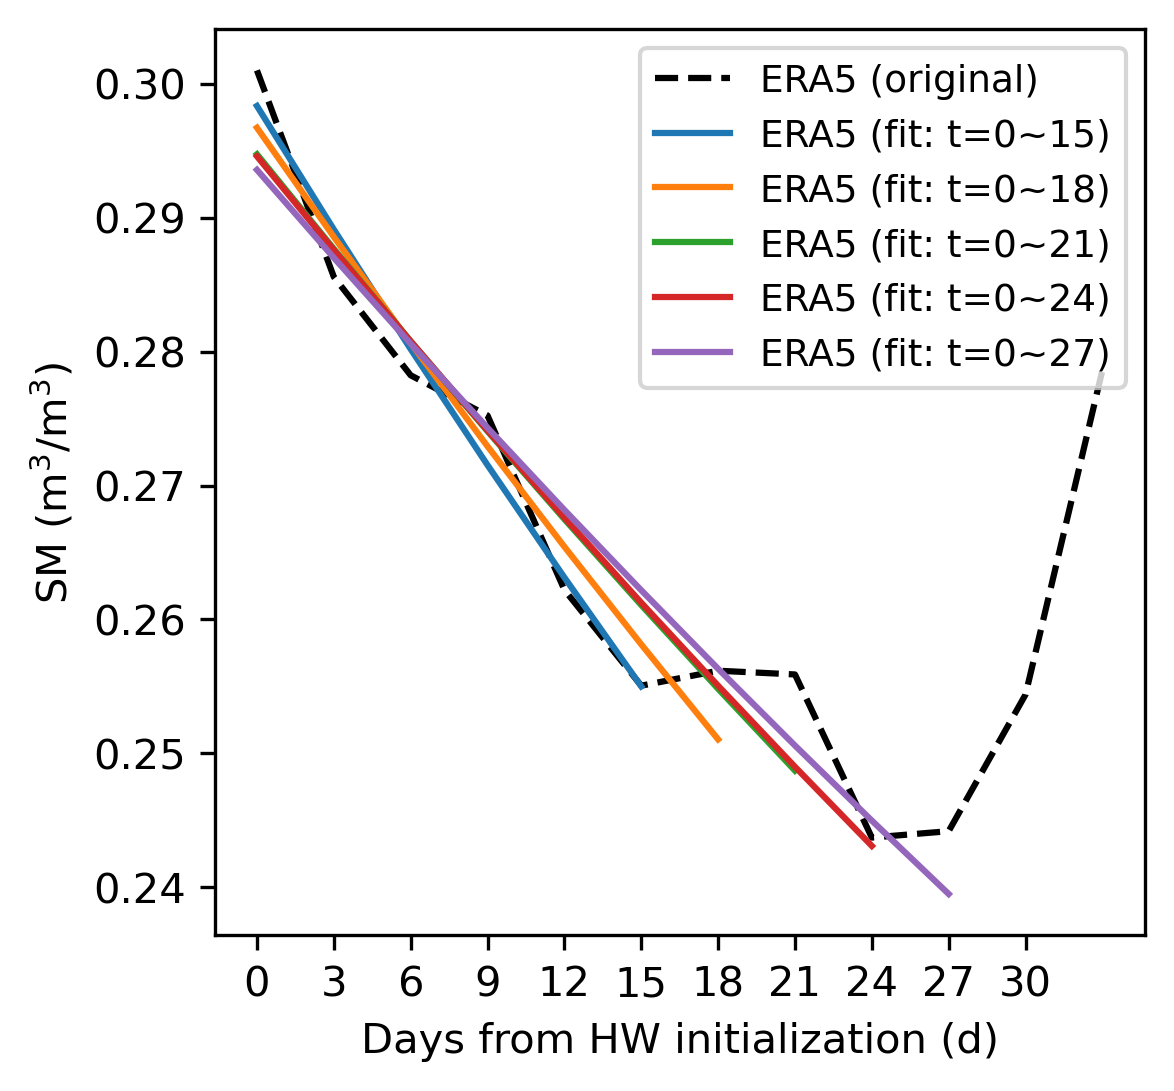

In [28]:
def exponential_func(x, a, b):
    return a * np.exp(b * x)
x_data = np.arange(12)
y_data = np.nanmean(HW_event_SM,axis=0)[:12]
plt.figure(figsize=(4,4),dpi=300)
plt.plot(x_data,y_data,label='ERA5 (original)', c='k',linestyle = '--')
for data_len in [5,6,7,8,9]:
   
    x_data = np.arange(data_len+1)
    y_data = np.nanmean(HW_event_SM,axis=0)[:data_len+1]
    # Perform the curve fit
    popt, pcov = curve_fit(exponential_func, x_data, y_data, p0=(-0.02, 1))  # Initial guess (a=1, b=1)

    # Extract the fitted parameters
    a_fit, b_fit = popt
    print(f"Fitted parameters: a={a_fit}, b={b_fit}")

    y_fit =  exponential_func(x_data, *popt)
    ##
    

    # for i in HW_event_SM:
    #     plt.plot(i[:data_len],c='k',alpha=0.1)
    
    plt.plot(x_data,y_fit, label='ERA5 (fit: t=0~'+str(data_len*3)+')')

plt.legend()

plt.legend(fontsize=9)
plt.xticks(range(11),np.arange(0,33,3))
# plt.xlim(0,4)
# plt.ylim(0.26,0.305)
plt.xlabel('Days from HW initialization (d)')
plt.ylabel('SM (m$^{3}$/m$^{3}$)')


# model change rate

In [29]:
data_len = 7+1
# 5 7 9

In [ ]:
model_CMIP6_o = ['EC-Earth3','NorESM2-MM','NorESM2-LM',
                  'ACCESS-CM2','CanESM5','IPSL-CM6A-LR',
                  'MPI-ESM1-2-HR','MPI-ESM1-2-LR',
                  'INM-CM4-8','INM-CM5-0','UKESM1-0-LL','MIROC6']

SM_change = []
SM_fit = []
SM_fit_a = []
SM_fit_b = []

###########################models
for i_ml in range(len(model_CMIP6_o )):
    JJA_index_ml = JJA_index_CMIP6[i_ml]
    ID_ml = model_CMIP6_o[i_ml]
    HW_flag_ml = HW_flag_CMIP6[i_ml]
    SM_region_ml = SM_region_CMIP6[i_ml]
    t2m_region_re_de_ml=t2m_region_re_de_CMIP6[i_ml]


    HW_event_start_ml = []
    HW_event_start_ml.append(0)
    for i in range(len(HW_flag_ml[:-1])):
        if HW_flag_ml[i+1]-HW_flag_ml[i]>1:
            HW_event_start_ml.append(i+1)

    HW_event_loc_ml = []
    for i in range(len(HW_event_start_ml[:-1])):
        peak_date = np.argmax(t2m_region_re_de_ml[JJA_index_ml][HW_flag_ml[HW_event_start_ml[i]:HW_event_start_ml[i+1]]])
        HW_event_loc_ml.append(HW_flag_ml[HW_event_start_ml[i]:HW_event_start_ml[i+1]])

    HW_event_SM_ml = np.zeros((len(HW_event_loc_ml),30))
    for i in range(len(HW_event_loc_ml)):
        HW_event_SM_ml[i,:len(HW_event_loc_ml[i])] = SM_region_ml[JJA_index_ml][HW_event_loc_ml[i]]
        HW_event_SM_ml[i,len(HW_event_loc_ml[i]):] = np.nan

    def exponential_func(x, a, b):
        return a * np.exp(b * x)
    

    x_data = np.arange(data_len)
    y_data = np.nanmean(HW_event_SM_ml,axis=0)[:data_len]
    # Perform the curve fit
    popt, pcov = curve_fit(exponential_func, x_data, y_data, p0=(-0.02, 1))  # Initial guess (a=1, b=1)

    # Extract the fitted parameters
    a_fit, b_fit = popt
    print(f"Fitted parameters: a={a_fit}, b={b_fit}")

    y_fit =  exponential_func(x_data, *popt)
    ##
    # plt.figure(figsize=(4,4))
    # for i in HW_event_SM_ml:
    #     plt.plot(i[:data_len],c='k',alpha=0.1)
    # plt.plot(x_data,y_data,c='k')
    # plt.plot(x_data,y_fit, label='Fitted curve', color='brown')
    SM_change.append(y_data)
    SM_fit.append(y_fit)
    SM_fit_a.append(popt[0])
    SM_fit_b.append(popt[1])

Fitted parameters: a=0.2534071487847665, b=-0.028367360830728675
Fitted parameters: a=0.2589651305282136, b=-0.01708938776595079
Fitted parameters: a=0.2356300481196106, b=-0.01633678749203113
Fitted parameters: a=0.19349152527056582, b=-0.018517026667111056
Fitted parameters: a=0.20437353692228694, b=-0.023570093657596422
Fitted parameters: a=0.17816276101079898, b=-0.001337130119520784
Fitted parameters: a=0.20407861475698122, b=-0.00964676254653422
Fitted parameters: a=0.21210895009999936, b=-0.010480399035589383
Fitted parameters: a=0.2071105096910255, b=-0.011974499216382481
Fitted parameters: a=0.21198583985563446, b=-0.00944445576355004
Fitted parameters: a=0.23672954339011168, b=-0.02586907969956967
Fitted parameters: a=0.2042028713444839, b=-0.011324438235241381
Fitted parameters: a=0.14090985442928125, b=-0.047213683648778794


Mean of empty slice


In [31]:
len(SM_region_CMIP6)

13

# SMILE change rate

In [32]:

SM_change_le = []
SM_fit_le = []
SM_fit_a_le = []
SM_fit_b_le = []

###########################models
for i_le in range(40):
    JJA_index_le = JJA_index_CMIP6[0]
    HW_flag_le = HW_flag_LE[i_le]
    SM_region_le = SM_region_LE[i_le]
    t2m_region_re_de_le=t2m_region_re_de_LE[i_le]

    HW_event_start_le = []
    HW_event_start_le.append(0)
    for i in range(len(HW_flag_le[:-1])):
        if HW_flag_le[i+1]-HW_flag_le[i]>1:
            HW_event_start_le.append(i+1)

    HW_event_loc_le = []
    for i in range(len(HW_event_start_le[:-1])):
        peak_date = np.argmax(t2m_region_re_de_le[JJA_index_le][HW_flag_le[HW_event_start_le[i]:HW_event_start_le[i+1]]])
        HW_event_loc_le.append(HW_flag_le[HW_event_start_le[i]:HW_event_start_le[i+1]])

    HW_event_SM_le = np.zeros((len(HW_event_loc_le),30))
    for i in range(len(HW_event_loc_le)):
        HW_event_SM_le[i,:len(HW_event_loc_le[i])] = SM_region_le[JJA_index_le][HW_event_loc_le[i]]
        HW_event_SM_le[i,len(HW_event_loc_le[i]):] = np.nan

    def exponential_func(x, a, b):
        return a * np.exp(b * x)
    
    x_data = np.arange(data_len)
    y_data = np.nanmean(HW_event_SM_le,axis=0)[:data_len]
    # Perform the curve fit
    popt, pcov = curve_fit(exponential_func, x_data, y_data, p0=(-0.02, 1))  # Initial guess (a=1, b=1)

    # Extract the fitted parameters
    a_fit, b_fit = popt
    print(f"Fitted parameters: a={a_fit}, b={b_fit}")

    y_fit =  exponential_func(x_data, *popt)
    ##
    # plt.figure(figsize=(4,4))
    # for i in HW_event_SM_le:
    #     plt.plot(i[:data_len],c='k',alpha=0.1)
    # plt.plot(x_data,y_data,c='k')
    # plt.plot(x_data,y_fit, label='Fitted curve', color='brown')
    SM_change_le.append(y_data)
    SM_fit_le.append(y_fit)
    SM_fit_a_le.append(popt[0])
    SM_fit_b_le.append(popt[1])

Mean of empty slice


Fitted parameters: a=0.26139298633152774, b=-0.024491470853229762
Fitted parameters: a=0.27254367324186923, b=-0.022435364692058705
Fitted parameters: a=0.2702166650182065, b=-0.017513000220163995
Fitted parameters: a=0.27134902844939335, b=-0.016063766921037614
Fitted parameters: a=0.27891300968352073, b=-0.020429720583478996
Fitted parameters: a=0.26709298585576946, b=-0.020927311640111447
Fitted parameters: a=0.275981069106744, b=-0.025736620514401818
Fitted parameters: a=0.2710774615588316, b=-0.0237545672941717
Fitted parameters: a=0.2691444764127282, b=-0.02796144191566552
Fitted parameters: a=0.2629227173075306, b=-0.018874879506070818
Fitted parameters: a=0.2707004965134796, b=-0.020979508203821065
Fitted parameters: a=0.27303975523762375, b=-0.02521486827299753
Fitted parameters: a=0.26642668132349284, b=-0.018699707312162656
Fitted parameters: a=0.26371563608109283, b=-0.01947138857941236
Fitted parameters: a=0.26765532476293674, b=-0.01576331420618638
Fitted parameters: a=0.

# plot ERA5 and model

In [ ]:
markers_ml = ['1','2','s','d','h','p','X','v','>','x','+','3','4','H']
model_CMIP6_o = ['EC-Earth3','NorESM2-MM','NorESM2-LM',
                  'ACCESS-CM2','CanESM5','IPSL-CM6A-LR',
                  'MPI-ESM1-2-HR','MPI-ESM1-2-LR',
                  'INM-CM4-8','INM-CM5-0','UKESM1-0-LL','MIROC6']

colors_ml = [
    '#e6194b',  # Red  
    '#3cb44b',  # Green  
    "#fcdb03",  # Yellow  
    "#4363d8e6",  # Blue  
    '#f58231',  # Orange  
    "#8419B6",  # Purple  

    "#0F5F47",  # Deep Teal (a cool color alternative to green)  
    "#b14c08",  # Dark Brown  
    "#0A20A0FF" ,  # Maroon (adds a strong, dark contrast)

    "#ffbec3",  # Lavender  
    "#a2ebb8b2",  # Dark Orange  
    "#589dd6a9",  # Steel Blue (replaces excess green tones)  
    "#41116857",  # Magenta
]



In [61]:
SM_fit_b_new = []
SM_fit_b_new.append (-0.024)
for i in SM_fit_b:
    SM_fit_b_new.append (i)

In [62]:
SM_fit_a_new = []
SM_fit_a_new.append (0.294)
for i in SM_fit_a:
    SM_fit_a_new.append (i)

# model dAIC

In [63]:
def piecewise_linear_sig(xx, x0, y0,yearyear):
    # Number of bootstrap samples
    n_bootstraps = 100

    # Container to hold the bootstrap slope estimates
    bootstrap_cp = []
    bootstrap_s2 = []
    bootstrap_y_linear = []
    bootstrap_y_piece = []
    bootstrap_dr2 = []
    bootstrap_dAIC = []
    bootstrap_r2_l = []
    bootstrap_r2_p = []
    bootstrap_s = []

    for ii in range(n_bootstraps):
    #     # for i in range(n_bootstraps):
        for i_year in range(1979,2024):


            bootstrap_sample = np.copy(range(len(x0)))

            # Resample with replacement of i_year
            indices_to_replace = np.where(yearyear==i_year)[0]
            indices_rest = [i for i in np.arange(len(x0)) if i not in indices_to_replace]

            # Replace the selected indices with new values from the rest data
            bootstrap_sample[indices_to_replace] = np.random.choice(indices_rest, size=len(indices_to_replace), replace=False)
        

            indices = bootstrap_sample
            xxx = x0[indices]
            yyy = y0[indices]
            
            try:
                params_piecewise, _ = curve_fit(piecewise_linear, xxx,yyy,bounds=([np.nanpercentile(xxx,0),-np.inf,-np.inf,-np.inf], [np.nanpercentile(xxx,100),np.inf,np.inf,np.inf]))
            except RuntimeError as e:
                continue
            y_pred_piecewise = piecewise_linear(xxx, *params_piecewise)
            y_pred_piecewise1 = piecewise_linear(xx, *params_piecewise)
            r2_piecewise, mse_piecewise, mae_piecewise = evaluate_fit(yyy, y_pred_piecewise)
            slope,int,cor = scipy.stats.linregress(xxx,yyy)[:3]
            y_pred_l = slope*xxx+int
            y_pred_l1 = slope*xx+int

            r2_l, mse_l, mae_l = evaluate_fit(yyy, y_pred_l)
            dr2 = r2_piecewise-r2_l

            aic_segmented = len(yyy) * np.log(mse_piecewise) + 2 * (4)
            aic_l = len(yyy) * np.log(mse_l) + 2 * (2)
            

            DAIC = aic_segmented-aic_l
            bootstrap_cp.append(params_piecewise[0])
            bootstrap_s2.append(params_piecewise[3])
            bootstrap_y_linear.append(y_pred_l1)
            bootstrap_y_piece.append(y_pred_piecewise1)
            bootstrap_dr2.append(dr2)
            bootstrap_dAIC.append(DAIC)
            bootstrap_r2_l.append(r2_l)
            bootstrap_r2_p.append(r2_piecewise)
            bootstrap_s.append(slope)

    return np.array(bootstrap_cp),np.array(bootstrap_s2),np.array(bootstrap_y_linear),np.array(bootstrap_y_piece),np.array(bootstrap_dr2),np.array(bootstrap_dAIC),np.array(bootstrap_r2_l),np.array(bootstrap_r2_p),np.array(bootstrap_s)


def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x: k1*x + y0-k1*x0, lambda x: k2*x + y0-k2*x0])

In [40]:
l_color = '#298c8c'
p_color = '#800074'

Mean of empty slice


-19.58843737415988
1979~2023


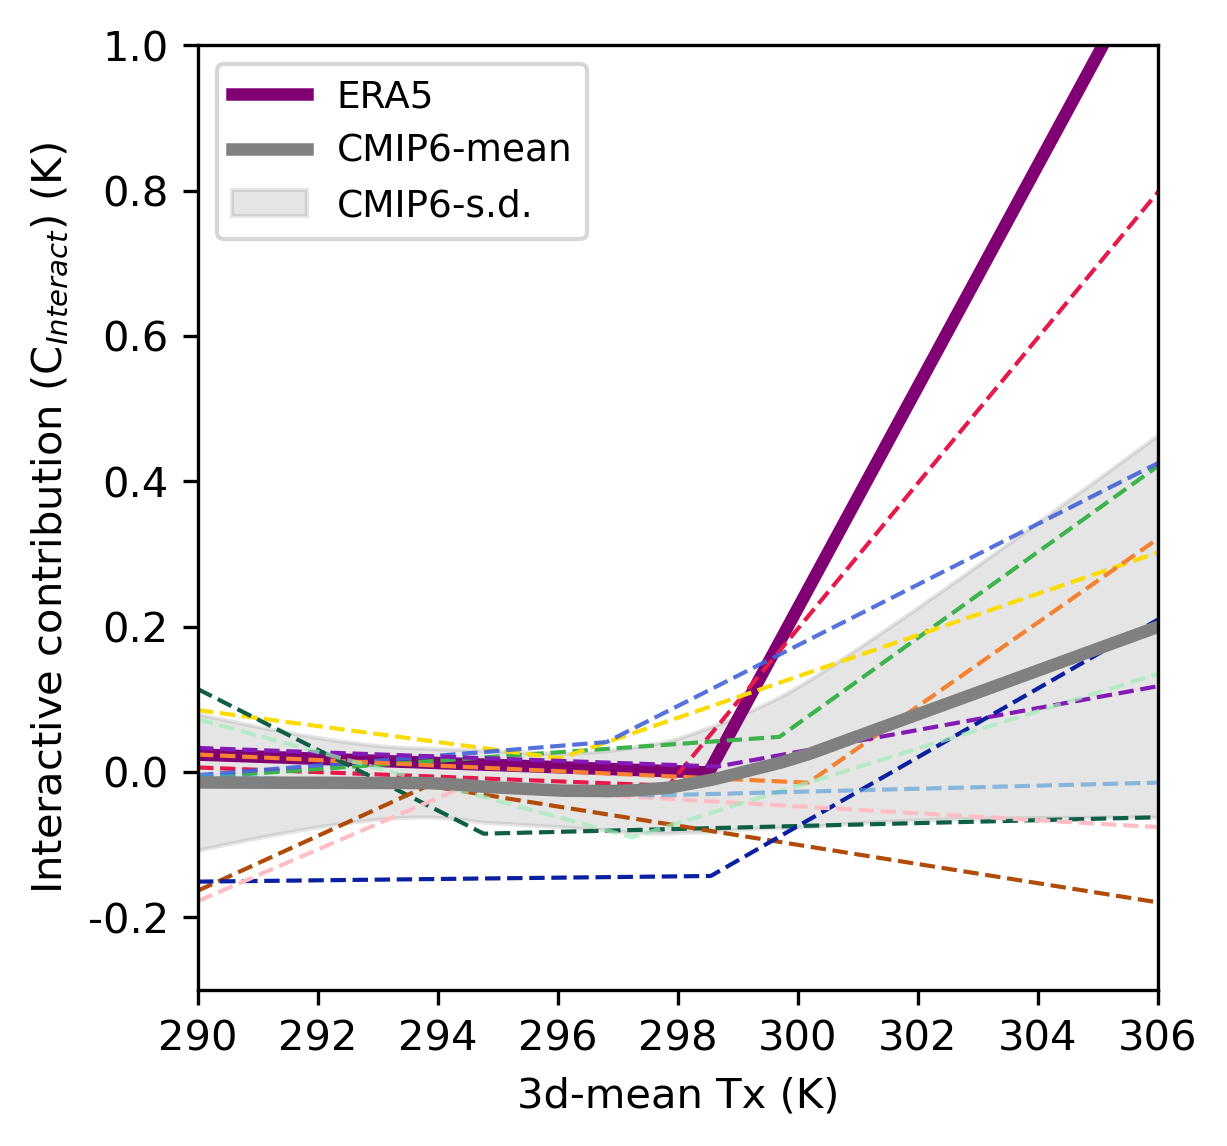

In [ ]:

def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x: k2*x + y0-k2*x0])

fig, ax1 = plt.subplots(figsize=(4,4.5),dpi=300)  # Create the main figure and axis


xx = np.arange(14,35,0.01)*1.0+272
xx_new = np.arange(290,307)

############# era5

x = t2m_region[JJA_index][HW_flag]
y = year_era5_all[JJA_index][HW_flag]
z = b_temp0[HW_flag]/b_temp3[HW_flag]*b_temp4[HW_flag]
index_where = np.where((y<=2023)&(y>=1979))[0]


xxx = x[index_where]
yyy = z[index_where]
yearyear = y[index_where]
nan_index = np.where((~(np.isnan(xxx))&(~np.isnan(yyy))))
xxx = xxx[nan_index]
yyy = yyy[nan_index]
yearyear = y[index_where]
# sns.kdeplot(xxx ,yyy,levels=[0.1],linewidths=0.5,linestyles='--',alpha=1,bw_adjust=1,color='k',ax=ax1,label='f: KDE [0.1]')

##################################
xx_temp_median = np.arange(np.nanmin(xxx),np.nanmax(xxx)+0.5,0.5)
yy_temp_median = []
yy_temp_90 = []
yy_temp_10 = []
yy_temp_all = []
for i_x in  xx_temp_median:
    temp = yyy[(xxx>i_x)&(xxx<=i_x+0.5)]
    yy_temp_median.append(np.nanpercentile(temp,50))
    yy_temp_90.append(np.nanpercentile(temp,90))
    yy_temp_10.append(np.nanpercentile(temp,10))
    yy_temp_all.append(temp)

xxx = copy.deepcopy(np.array(xx_temp_median))
yyy = copy.deepcopy(np.array(yy_temp_median))
nan_index = np.where((~(np.isnan(xxx))&(~np.isnan(yyy))))
xxx = xxx[nan_index]
yyy = yyy[nan_index]
#######################################

params_piecewise, _ = curve_fit(piecewise_linear, xxx,yyy,bounds=([np.nanpercentile(xxx,0),-np.inf,-np.inf,-np.inf], [np.nanpercentile(xxx,100),np.inf,np.inf,np.inf]))
y_pred_piecewise = piecewise_linear(xxx, *params_piecewise)
y_pred_piecewise1 = piecewise_linear(xx, *params_piecewise)
r2_piecewise, mse_piecewise, mae_piecewise = evaluate_fit(yyy, y_pred_piecewise)
slope,int,cor = scipy.stats.linregress(xxx,yyy)[:3]
y_pred_l = slope*xxx+int
y_pred_l1 = slope*xx+int

r2_l, mse_l, mae_l = evaluate_fit(yyy, y_pred_l)
dr2 = r2_piecewise-r2_l

aic_segmented = len(yyy) * np.log(mse_piecewise) + 2 * (4)
aic_l = len(yyy) * np.log(mse_l) + 2 * (2)
DAIC = aic_segmented-aic_l

ax1.plot(xx, y_pred_piecewise1, label='ERA5',linewidth=3,linestyle='-',c=p_color)
print(DAIC)


###########################models
y_pred_piecewise1_ml_all = []
for i_ml in range(len(model_CMIP6_o)):
    if SM_fit_b[i_ml]<-0.04:
        continue
    
    JJA_index_ml = JJA_index_CMIP6[i_ml]
    ID_ml = model_CMIP6_o[i_ml]
    HW_flag_ml = HW_flag_CMIP6[i_ml]
    year_era5_all_ml  = year_era5_all_CMIP6[i_ml]
    basevalue1_0_ml = JJA_mean_CMIP6[i_ml]
    basevalue1_0_ml_diff = basevalue1_0_ml-basevalue1_0

    basevalue1_0_ml = basevalue1_0_ml-basevalue1_0_ml_diff




    x_ml = t2m_region_CMIP6[i_ml][JJA_index_ml][HW_flag_ml]
    x_ml = x_ml-basevalue1_0_ml_diff
    
    y_ml = year_era5_all_ml[JJA_index_ml][HW_flag_ml]
    z_ml = b_temp0_CMIP6[i_ml][HW_flag_ml]
  


    index_where = np.where((y_ml<=2023)&(y_ml>=1979))[0]


    xxx = x_ml[index_where]
    yyy = z_ml[index_where]
    yearyear = y_ml[index_where]

    nan_index = np.where((~(np.isnan(xxx))&(~np.isnan(yyy))))
    xxx = xxx[nan_index]
    yyy = yyy[nan_index]
    yearyear = y_ml[index_where]


#############################  
    xx_temp_median = np.arange(np.nanmin(xxx),np.nanmax(xxx)+0.5,0.5)
    yy_temp_median = []
    yy_temp_90 = []
    yy_temp_10 = []
    yy_temp_all = []
    for i_x in  xx_temp_median:
        temp = yyy[(xxx>i_x)&(xxx<=i_x+0.5)]
        yy_temp_median.append(np.nanpercentile(temp,50))
        yy_temp_90.append(np.nanpercentile(temp,90))
        yy_temp_10.append(np.nanpercentile(temp,10))
        yy_temp_all.append(temp)

    xxx = copy.deepcopy(np.array(xx_temp_median))
    yyy = copy.deepcopy(np.array(yy_temp_median))
    nan_index = np.where((~(np.isnan(xxx))&(~np.isnan(yyy))))
    xxx = xxx[nan_index]
    yyy = yyy[nan_index]

##############################  
    params_piecewise, _ = curve_fit(piecewise_linear, xxx,yyy,bounds=([np.nanpercentile(xxx,0),-np.inf,-np.inf,-np.inf], [np.nanpercentile(xxx,100),np.inf,np.inf,np.inf]))
    y_pred_piecewise = piecewise_linear(xxx, *params_piecewise)
    y_pred_piecewise1 = piecewise_linear(xx, *params_piecewise)
    r2_piecewise, mse_piecewise, mae_piecewise = evaluate_fit(yyy, y_pred_piecewise)
    slope,int,cor = scipy.stats.linregress(xxx,yyy)[:3]
    y_pred_l = slope*xxx+int
    y_pred_l1 = slope*xx+int

    r2_l, mse_l, mae_l = evaluate_fit(yyy, y_pred_l)
    dr2 = r2_piecewise-r2_l

    aic_segmented = len(yyy) * np.log(mse_piecewise) + 2 * (4)
    aic_l = len(yyy) * np.log(mse_l) + 2 * (2)
    DAIC = aic_segmented-aic_l
   


    ax1.plot(xx, y_pred_piecewise1, linestyle='--',c=colors_ml[i_ml],linewidth=1)


#################################################################
    y_pred_piecewise1_ml_all.append(y_pred_piecewise1)


#################################################################
ax1.plot(xx, np.nanmean(y_pred_piecewise1_ml_all,axis=0), linestyle='-',c='grey',linewidth=3,alpha=1,label='CMIP6-mean')
ax1.fill_between(xx,np.nanmean(y_pred_piecewise1_ml_all ,axis=0)-np.nanstd(y_pred_piecewise1_ml_all ,axis=0),np.nanmean(y_pred_piecewise1_ml_all ,axis=0)+np.nanstd(y_pred_piecewise1_ml_all,axis=0),color='grey',alpha=0.2,label='CMIP6-s.d.')
# for i_le in range(0,40):
# ax1.axhline(0,color='grey',linestyle='--')

# ax1.axhline(0,color='grey',linestyle='--')
ax1.set_yticks(np.arange(-0.4,1.2,0.2))
ax1.set_ylim(-0.3,1)
ax1.set_ylabel('Interactive contribution (C$_{Interact}$) (K)')

ax1.set_xticks(xx_new[::2])
ax1.set_xticklabels(xx_new[::2])
ax1.set_xlim((xx_new[0],xx_new[-1]))
ax1.set_xticklabels([np.int(np.round(tick)) for tick in ax1.get_xticks()]) 
ax1.set_xlabel('3d-mean Tx (K)')

ax1.tick_params(axis='y',  # changes apply to the y-axis
                which='both',  # both major and minor ticks are affected
                direction='out')  # ticks are drawn outside the plot
ax1.set_yticklabels([f'{tick:.1f}'for tick in ax1.get_yticks()])
ax1.legend(fontsize=9)
# ax1.legend(fontsize=9,loc='upper left',bbox_to_anchor=(1.02, 0.99))
plt.subplots_adjust(left=0.1,right=0.9,bottom=0.25,top=0.95)

print('1979~2023')



In [85]:
def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x: k2*x + y0-k2*x0])

In [ ]:
T995_change_all = []
Tc_per_change_all = []

dAIC_all = []
cp_all = []
slope_interact_all = []

ttt_jja_all_all = []
Tc_per_all_all = []

xx = np.arange(14,35,0.01)*1.0+272
xx_new = np.arange(290,307)

############# era5


x = t2m_region[JJA_index][HW_flag]
y = year_era5_all[JJA_index][HW_flag]
z = b_temp0[HW_flag]/b_temp3[HW_flag]*b_temp4[HW_flag]
index_where = np.where((y<=2023)&(y>=1979))[0]

xxx = x[index_where]
yyy = z[index_where]
yearyear = y[index_where]
nan_index = np.where((~(np.isnan(xxx))&(~np.isnan(yyy))))
xxx = xxx[nan_index]
yyy = yyy[nan_index]
yearyear = y[nan_index]


########################
xx_temp_median = np.arange(np.nanmin(xxx),np.nanmax(xxx)+0.5,0.5)
yy_temp_median = []
yy_temp_90 = []
yy_temp_10 = []
yy_temp_all = []
for i_x in  xx_temp_median:
    temp = yyy[(xxx>i_x)&(xxx<=i_x+0.5)]
    yy_temp_median.append(np.nanpercentile(temp,50))
    yy_temp_90.append(np.nanpercentile(temp,90))
    yy_temp_10.append(np.nanpercentile(temp,10))
    yy_temp_all.append(temp)


xxx = copy.deepcopy(np.array(xx_temp_median))
yyy = copy.deepcopy(np.array(yy_temp_median))
nan_index = np.where((~(np.isnan(xxx))&(~np.isnan(yyy))))
xxx = xxx[nan_index]
yyy = yyy[nan_index]


########################
params_piecewise, _ = curve_fit(piecewise_linear, xxx,yyy,bounds=([np.nanpercentile(xxx,0),-np.inf,-np.inf,-np.inf], [np.nanpercentile(xxx,100),np.inf,np.inf,np.inf]))
y_pred_piecewise = piecewise_linear(xxx, *params_piecewise)
y_pred_piecewise1 = piecewise_linear(xx, *params_piecewise)
r2_piecewise, mse_piecewise, mae_piecewise = evaluate_fit(yyy, y_pred_piecewise)
slope,int,cor = scipy.stats.linregress(xxx,yyy)[:3]
y_pred_l = slope*xxx+int
y_pred_l1 = slope*xx+int

r2_l, mse_l, mae_l = evaluate_fit(yyy, y_pred_l)
dr2 = r2_piecewise-r2_l

aic_segmented = len(yyy) * np.log(mse_piecewise) + 2 * (4)
aic_l = len(yyy) * np.log(mse_l) + 2 * (2)
print(aic_segmented-aic_l)
DAIC = aic_segmented-aic_l



# bootstrap_cp,bootstrap_s2,bootstrap_y_linear,bootstrap_y_piece,bootstrap_dr2,bootstrap_dAIC,bootstrap_r2_l,bootstrap_r2_p,bootstrap_s = piecewise_linear_sig(xx, xxx,yyy,yearyear)

dAIC_all.append(DAIC)
cp_all.append(params_piecewise[0])
slope_interact_all.append(params_piecewise[3])

ttt_jja = t2m_region[JJA_index]
yyy_jja = year_era5_all[JJA_index]
ttt_jja1 = ttt_jja[np.in1d(yyy_jja,np.arange(2003,2024))]
ttt_jja2 = ttt_jja[np.in1d(yyy_jja,np.arange(1979,2000))]
ttt_jja_all = []
for i_y in range(1979,2024):
    ttt_jja_all.append(np.nanpercentile(ttt_jja[np.in1d(yyy_jja,np.arange(i_y,i_y+1))],99.5))
ttt_jja_all_all.append( np.array(ttt_jja_all))
# T995_change_all.append(np.nanpercentile(ttt_jja1,99.5)-np.nanpercentile(ttt_jja2,99.5))
T995_change_all.append(np.nanpercentile(ttt_jja_all[-20:],50)-np.nanpercentile(ttt_jja_all[:20],50))
Tc_per_change_all.append(len(ttt_jja1[ttt_jja1>=params_piecewise[0]])/len(ttt_jja1)-len(ttt_jja2[ttt_jja2>=params_piecewise[0]])/len(ttt_jja2))

Tc_per_all = []
for i_y in range(1979,2024):
    temp = ttt_jja[np.in1d(yyy_jja,np.arange(i_y,i_y+1))]
    Tc_per_all.append(len(temp[temp>=params_piecewise[0]])/len(temp))
Tc_per_all_all.append( np.array(Tc_per_all))
###########################models

for i_ml in range(12):
    ID_ml = model_CMIP6_o[i_ml]
    JJA_index_ml = JJA_index_CMIP6[i_ml]
    HW_flag_ml = HW_flag_CMIP6[i_ml]

    x_ml = t2m_region_CMIP6[i_ml][JJA_index_ml][HW_flag_ml]
    year_era5_all_ml  = year_era5_all_CMIP6[i_ml]
    y_ml = year_era5_all_ml[JJA_index_ml][HW_flag_ml]
    z_ml = b_temp0_CMIP6[i_ml][HW_flag_ml]
    basevalue1_0_ml = JJA_mean_CMIP6[i_ml]
    index_where = np.where((y_ml<=2023)&(y_ml>=1979))[0]


    xxx = x_ml[index_where]
    yyy = z_ml[index_where]
    yearyear = y_ml[index_where]

    nan_index = np.where((~(np.isnan(xxx))&(~np.isnan(yyy))))
    xxx = xxx[nan_index]
    yyy = yyy[nan_index]
    yearyear = y_ml[index_where]



###################################
    params_piecewise, _ = curve_fit(piecewise_linear, xxx,yyy,bounds=([np.nanpercentile(xxx,0),-np.inf,-np.inf,-np.inf], [np.nanpercentile(xxx,100),np.inf,np.inf,np.inf]))
    y_pred_piecewise = piecewise_linear(xxx, *params_piecewise)
    y_pred_piecewise1 = piecewise_linear(xx, *params_piecewise)
    r2_piecewise, mse_piecewise, mae_piecewise = evaluate_fit(yyy, y_pred_piecewise)
    slope,int,cor = scipy.stats.linregress(xxx,yyy)[:3]
    y_pred_l = slope*xxx+int
    y_pred_l1 = slope*xx+int

    r2_l, mse_l, mae_l = evaluate_fit(yyy, y_pred_l)
    dr2 = r2_piecewise-r2_l

    aic_segmented = len(yyy) * np.log(mse_piecewise) + 2 * (4)
    aic_l = len(yyy) * np.log(mse_l) + 2 * (2)
    DAIC = aic_segmented-aic_l

    print(aic_segmented-aic_l)

    dAIC_all.append(DAIC)
    cp_all.append(params_piecewise[0]) 
    slope_interact_all.append(params_piecewise[3])

    ttt = t2m_region_CMIP6[i_ml]
    ttt_jja = ttt[JJA_index_ml]
    yyy_jja = year_era5_all_ml[JJA_index_ml]
    ttt_jja1 = ttt_jja[np.in1d(yyy_jja,np.arange(2003,2024))]
    ttt_jja2 = ttt_jja[np.in1d(yyy_jja,np.arange(1979,2000))]
    ttt_jja_all = []
    for i_y in range(1979,2024):
        ttt_jja_all.append(np.nanpercentile(ttt_jja[np.in1d(yyy_jja,np.arange(i_y,i_y+1))],99.5))

    ttt_jja_all_all.append( np.array(ttt_jja_all))


    T995_change_all.append(np.nanpercentile(ttt_jja_all[-20:],50)-np.nanpercentile(ttt_jja_all[:20],50))
    Tc_per_change_all.append(len(ttt_jja1[ttt_jja1>=params_piecewise[0]])/len(ttt_jja1)-len(ttt_jja2[ttt_jja2>=params_piecewise[0]])/len(ttt_jja2))

    Tc_per_all = []
    for i_y in range(1979,2024):
        temp = ttt_jja[np.in1d(yyy_jja,np.arange(i_y,i_y+1))]
        Tc_per_all.append(len(temp[temp>=params_piecewise[0]])/len(temp))
    Tc_per_all_all.append( np.array(Tc_per_all))

Mean of empty slice


-19.58843737415988
-13.001794430655195
-2.78790740347074
-2.520975963865567
1.9149755485303785
-4.785022743437594
-1.1599619038136098
-0.22294369437236128
-1.5925807755129426
-6.272510812566566
0.7060932561230402
-6.32327653421612
3.1484423150002385
3.5558426691045497


In [67]:
Tc_per_change_all = np.array(Tc_per_change_all)
T995_change_all = np.array(T995_change_all)

## eet

In [68]:
SM_fit_b_new_plot =  copy.deepcopy(-np.array(SM_fit_b_new))*100
SM_fit_b_le_plot =  copy.deepcopy(-np.array(SM_fit_b_le))*100

In [69]:
SM_fit_a_new_plot =  copy.deepcopy(np.array(SM_fit_a_new))
SM_fit_a_le_plot =  copy.deepcopy(np.array(SM_fit_a_le))


# stat regress

In [70]:
xx_pred = np.arange(-0.01,0.04,0.005)*100

LinregressResult(slope=-0.38440306647859057, intercept=-1.5734871016294893, rvalue=-0.09774036525396221, pvalue=0.7507425738615111, stderr=1.1801361786809035)
LinregressResult(slope=-3.65595327016303, intercept=2.86304252968422, rvalue=-0.6513370598117904, pvalue=0.02176596336297767, stderr=1.3468387545433707)


(-22.0, 5.0)

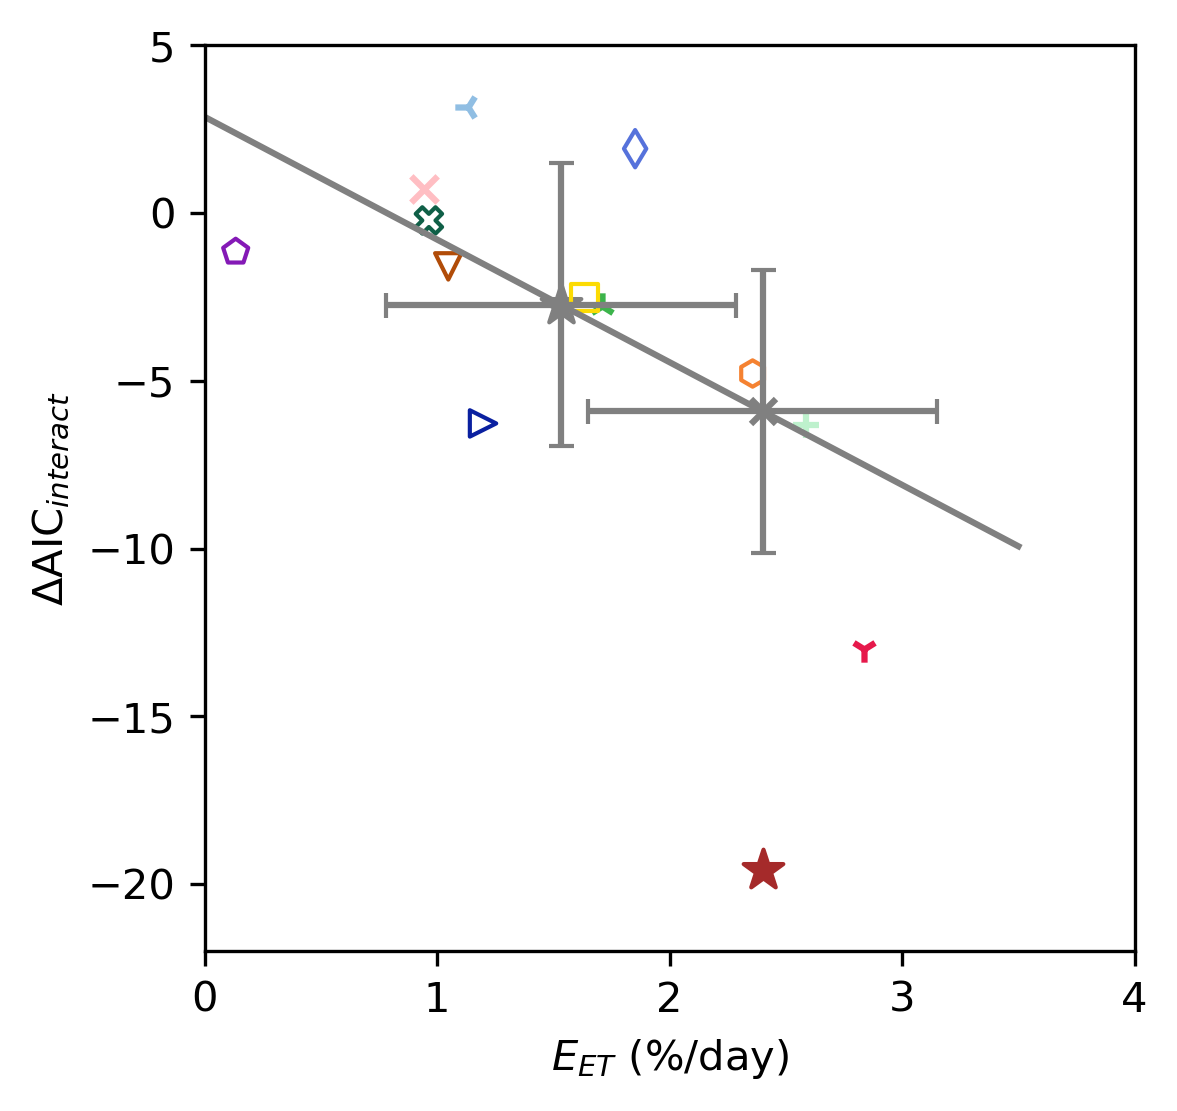

In [ ]:
xxx = np.array(SM_fit_b_new_plot)
yyy = np.array(dAIC_all)



slope,int,cor = scipy.stats.linregress(xxx[1:],yyy[1:])[:3]
y_pred_l1 = slope*xx_pred+int


plt.figure(figsize=(4,4),dpi=300)
plt.scatter(xxx[0],yyy[0],marker='*',c='brown',s=100,label='ERA5')


xxx_mean = []
yyy_mean = []
ml_number = 0
for i_ml in range(12):

    xxx_mean.append(xxx[i_ml+1])
    yyy_mean.append(yyy[i_ml+1])
    ml_number = ml_number+1



plt.errorbar(np.nanmean(xxx_mean),np.nanmean(yyy_mean), xerr=np.nanstd(xxx_mean), yerr=np.nanstd(yyy_mean), color='grey', capsize=3)
plt.scatter(np.nanmean(xxx_mean),np.nanmean(yyy_mean),marker='*',s=100,c='grey',label='CMIP6-mean')

plt.scatter(xxx[0],slope*xxx[0]+int,marker='x',c='grey',label='Adjusted CMIP6-mean')
plt.errorbar(xxx[0],slope*xxx[0]+int, xerr=np.nanstd(xxx_mean), yerr=np.nanstd(yyy_mean), color='grey', capsize=3,label='CMIP6-s.d.')


for i_ml in range(12):


    if markers_ml[i_ml] not in ['+','x','1','2','3','4']:
        plt.scatter(xxx[i_ml+1],yyy[i_ml+1],facecolors='none',edgecolors=colors_ml[i_ml],marker=markers_ml[i_ml],label=model_CMIP6_o[i_ml],s=40)
    else:
        plt.scatter(xxx[i_ml+1],yyy[i_ml+1],color=colors_ml[i_ml],marker=markers_ml[i_ml],label=model_CMIP6_o[i_ml],s=40)



plt.plot(xx_pred,y_pred_l1 ,c='grey',linestyle='-',label='CMIP6 intermodel regression')

plt.xlabel('${E_{ET}}$ (%/day)')
plt.ylabel('${\Delta}$AIC$_{interact}$')
plt.xlim(0,4)

plt.ylim(-22,5)

